# AI Homework: n-Queens problem

The N-Queens Problem is a classic benchmark in the field of Artificial Intelligence. The challenge involves placing $n$ non-attacking queens on an $n \times n$ chessboard such that no two queens share the same row, column, or diagonal. This problem serves as an excellent model for exploring Constraint Satisfaction Problems (CSPs) and evaluating the performance of search algorithms, ranging from simple backtracking to more advanced heuristic-based approaches. In this notebook the A* algorithm is going to be implemented and tested and a Reduction to CSP is applied.

## Representation of the Board
To represent the chess board is used an array, and each position of the board is the following:
- the column correspond to the index of the position in the array;
- the row correspond to the value in a specific position in the array.
So for example, the in the following array board = [2, 0, 3, 1], the queens are placed in this way

In [42]:
def print_board(queens, N):
    print(f'Board: {queens}\n')
    # If the representation is a partial representation, we print only the placed queens, the other columns will be empty
    for row in range(N):
        row_cells = []
        for col in range(N):
            # Print the "Q" in the position [queens[col], col]
            if queens[col] == row:
                row_cells.append("Q")
            else:
                row_cells.append(" ")
        
        print(f"       [{', '.join(row_cells)}]")

print_board([2, 0, 3, 1], 4)

Board: [2, 0, 3, 1]

       [ , Q,  ,  ]
       [ ,  ,  , Q]
       [Q,  ,  ,  ]
       [ ,  , Q,  ]


## 1. A* Implementation
### A* components
The A* algorithm chooses the next node to expand, computing the function 
$$f(n) = g(n) + h(n)$$
where:
- $g(n)$ is the cost of the path so far, so the number of queens that has been moved respect to the initial state;
- $h(n)$ is the heuristic function, that computes the number of conflicts for the current state.
The goal is to reach a state where $h(n) = 0$, so there are no queens attacking each other.

### Board Class
In the `Board` class are stored the dimension of the problem `N` and the current configuration of the board in the variable `queens`. The function `heuristic()` computes the number of couples that are in conflict in the current state and the function `get_successors()` computes all the successors of the current state. The function `print_board()` is just an auxiliary function to print the board in matrix form and the heuristic value, to visualize the current state of the board.

In [43]:
class Board:
    def __init__(self, N, initial_configuration=None):
        self.N = N
        if initial_configuration is None:
            # If no initial configuration is given, all queens are placed on the row 0
            self.queens = [0] * N
        else:
            self.queens = list(initial_configuration)

    def heuristic(self):
        # Computes the number of couples in conflict
        conflicts = 0
        n = len(self.queens)
        for i in range(n):
            for j in range(i + 1, n):
                # Row check
                if self.queens[i] == self.queens[j]:
                    conflicts += 1
                # Diagonal check
                elif abs(self.queens[i] - self.queens[j]) == abs(i - j):
                    conflicts += 1
        return conflicts

    def get_successors(self):
        # Generates all the successors, changing the row of one queen
        successors = []
        for col in range(self.N):
            original_row = self.queens[col]
            for row in range(self.N):
                if row != original_row:
                    new_queens = list(self.queens)
                    new_queens[col] = row
                    successors.append(Board(self.N, new_queens))
        return successors
    
    def print_board(self,):
        h = self.heuristic()
        print(f'Board: {self.queens}, h = {h}\n')
        for row in range(self.N):
            row_cells = []
            for col in range(self.N):
                # Print the "Q" in the position [queens[col], col]
                if self.queens[col] == row:
                    row_cells.append("Q")
                else:
                    row_cells.append(" ")
            
            print(f"       [{', '.join(row_cells)}]")
        


### A* Algorithm
It is explicitly asked to implement the algorithm in the version with duplicate elimination and no re-opening.

In [44]:
import heapq

def a_star_search(initial_state, N):
    # node n with n.State = problem.InitialState
    start_state = tuple(initial_state)
    start_h = Board(N, initial_state).heuristic()
    
    # frontier <- a priority queue ordered by ascending g + h, only element n
    # Frontier element: [f_score, g_score, state_tuple]
    frontier_pq = [[0 + start_h, 0, start_state]]
    
    # States(frontier): Dizionario per tenere traccia dei costi g dei nodi in frontiera
    frontier_states = {start_state: 0} 
    
    # explored <- empty set of states
    explored = set()
    
    # Metrics
    nodes_explored_count = 0
    branching_factors = [] 

    # loop do
    while frontier_pq:
        # if Empty?(frontier) then return failure [if we exit the while, failure is returned]
        
        # n <- Pop(frontier)
        n_f, n_g, n_state = heapq.heappop(frontier_pq)

        if n_state in explored or (n_state in frontier_states and frontier_states[n_state] < n_g):
            continue
            
        # Removing state from frontier_states to explore
        if n_state in frontier_states:
            del frontier_states[n_state]

        # if problem.GoalTest(n.State) then return Solution(n)
        current_board = Board(N, list(n_state))
        if current_board.heuristic() == 0:
            avg_b = sum(branching_factors) / len(branching_factors) if branching_factors else 0
            return {
                "solution": list(n_state),
                "cost_g": n_g,
                "explored_count": nodes_explored_count,
                "avg_branching": avg_b,
                "max_branching": max(branching_factors) if branching_factors else 0,
                "min_branching": min(branching_factors) if branching_factors else 0
            }

        # explored <- explored U n.State
        explored.add(n_state)
        nodes_explored_count += 1
        
        effective_children_this_node = 0

        # for each action a in problem.Actions(n.State) do
        # n' <- ChildNode(problem, n, a)
        for child_board in current_board.get_successors():
            child_state = tuple(child_board.queens)
            
            # Child costs
            child_g = n_g + 1                   # g(n') = g(n) + 1
            child_h = child_board.heuristic()   # h(n')
            child_f = child_g + child_h         # f(n') = g(n') + h(n')

            # if n'.State NOT IN (explored U States(frontier))
            if child_state not in explored and child_state not in frontier_states:
                # Insert(n', f, frontier)
                heapq.heappush(frontier_pq, [child_f, child_g, child_state])
                frontier_states[child_state] = child_g
                effective_children_this_node += 1
            
            # else if ex. n'' IN frontier s.t. n''.State = n'.State AND g(n') < g(n'')
            elif child_state in frontier_states:
                if child_g < frontier_states[child_state]:
                    # replace n'' in frontier with n'
                    frontier_states[child_state] = child_g
                    heapq.heappush(frontier_pq, [child_f, child_g, child_state])
                    effective_children_this_node += 1
        
        branching_factors.append(effective_children_this_node)

    return None # Failure

## Test of the algorithm
To check the correct execution of the algorith, different tests are performed. For the reproducibility of the experiment, the initial configurations are not generated randomly, those was chosen trying to capture interesting cofnigurations. 

In [45]:
import time

test_dict = {
    "test1":  {"N": 4,   "initial": [0, 0, 0, 0]},
    "test2":  {"N": 4,   "initial": [0, 1, 2, 3]},
    "test3":  {"N": 5,   "initial": [4, 3, 2, 1, 0]},
    "test4":  {"N": 6,   "initial": [0, 2, 4, 1, 3, 5]},
    "test5":  {"N": 8,   "initial": [0, 0, 0, 0, 0, 0, 0, 0]},
    "test6":  {"N": 8,   "initial": [7, 6, 5, 4, 3, 2, 1, 0]},
    "test7":  {"N": 10,  "initial": [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]},
    "test8":  {"N": 12,  "initial": [0, 2, 4, 6, 8, 10, 1, 3, 5, 7, 9, 11]},
    "test9":  {"N": 14,  "initial": [0, 2, 1, 3, 4, 6, 5, 7, 8, 10, 9, 11, 12, 13]},
    "test10": {"N": 15,  "initial": [i % 2 for i in range(15)]},
    "test11": {"N": 16,  "initial": [i for i in range(16)]},
    "test12": {"N": 18,  "initial": [0, 2, 4, 6, 8, 10, 12, 14, 16, 1, 3, 5, 7, 9, 11, 13, 15, 17]},
    "test13": {"N": 20,  "initial": [i % 4 for i in range(20)]},
    "test14": {"N": 22,  "initial": [i % 3 for i in range(22)]},
    "test15": {"N": 24,  "initial": [0] * 24},
    "test16": {"N": 25,  "initial": [12] * 25},
    "test17": {"N": 26,  "initial": [i % 4 for i in range(26)]},
    "test18": {"N": 28,  "initial": [0, 7, 14, 21] * 7},
    "test19": {"N": 30,  "initial": [i % 5 for i in range(30)]},
    "test20": {"N": 30,  "initial": [0, 5, 10, 15, 20, 25] * 5}
}

print("=== STARTING TEST SUITE: A* ON N-QUEENS ===")

# List to store metrics for final analysis
all_results = []

for test_id in sorted(test_dict.keys(), key=lambda x: int(x[4:])):
    data = test_dict[test_id]
    N = data["N"]
    initial = data["initial"]
    
    print(f"\n{'='*60}")
    print(f"EXPERIMENT: {test_id} (N={N})")
    print(f"{'='*60}")
    
    print("INITIAL STATE:")
    print_board(initial, N)
    print(f"Initial heuristic value (h): {Board(N, initial).heuristic()}")
    
    start_t = time.time()
    res = a_star_search(initial, N)
    end_t = time.time()
    elapsed = end_t - start_t
    
    if res:
        print(f"\nFINAL STATE (Solution Found):")
        print_board(res['solution'], N)
        print(f"\nMETRICS:")
        print(f"- Execution Time: {elapsed:.4f} s")
        print(f"- Visited Nodes: {res['explored_count']}")
        print(f"- Path Cost (g): {res['cost_g']}")
        print(f"- Average Branching Factor: {res['avg_branching']:.2f}")

        # Storing data for the summary table and charts
        all_results.append({
            "Test_ID": test_id,
            "N": N,
            "Visited Nodes": res['explored_count'],
            "Path Cost": res['cost_g'],
            "Average Branching Factor": res['avg_branching'],
            "Time": elapsed
        })
        
    else:
        print("\nRESULT: Failure (No solution found).")
    
    print(f"{'-'*60}")

=== STARTING TEST SUITE: A* ON N-QUEENS ===

EXPERIMENT: test1 (N=4)
INITIAL STATE:
Board: [0, 0, 0, 0]

       [Q, Q, Q, Q]
       [ ,  ,  ,  ]
       [ ,  ,  ,  ]
       [ ,  ,  ,  ]
Initial heuristic value (h): 6

FINAL STATE (Solution Found):
Board: [2, 0, 3, 1]

       [ , Q,  ,  ]
       [ ,  ,  , Q]
       [Q,  ,  ,  ]
       [ ,  , Q,  ]

METRICS:
- Execution Time: 0.0001 s
- Visited Nodes: 4
- Path Cost (g): 3
- Average Branching Factor: 9.00
------------------------------------------------------------

EXPERIMENT: test2 (N=4)
INITIAL STATE:
Board: [0, 1, 2, 3]

       [Q,  ,  ,  ]
       [ , Q,  ,  ]
       [ ,  , Q,  ]
       [ ,  ,  , Q]
Initial heuristic value (h): 6

FINAL STATE (Solution Found):
Board: [2, 0, 3, 1]

       [ , Q,  ,  ]
       [ ,  ,  , Q]
       [Q,  ,  ,  ]
       [ ,  , Q,  ]

METRICS:
- Execution Time: 0.0001 s
- Visited Nodes: 8
- Path Cost (g): 4
- Average Branching Factor: 7.88
------------------------------------------------------------

EXPERIMEN


=== METRICS SUMMARY FOR A* ===


,Test ID,Dimension N,Nodes Visited,Path Cost (g),Branching Factor,Time (s)
0,test1,4,4,3,9.000000,0.000100
1,test2,4,8,4,7.875000,0.000142
2,test3,5,5,4,16.200000,0.000173
3,test4,6,66,4,17.409091,0.003943
4,test5,8,14,8,47.714286,0.002030
5,test6,8,64,9,42.640625,0.010101
6,test7,10,30,10,79.133333,0.010324
7,test8,12,253,4,96.110672,0.172285
8,test9,14,77,13,158.402597,0.095407
9,test10,15,293,15,180.846416,0.474918


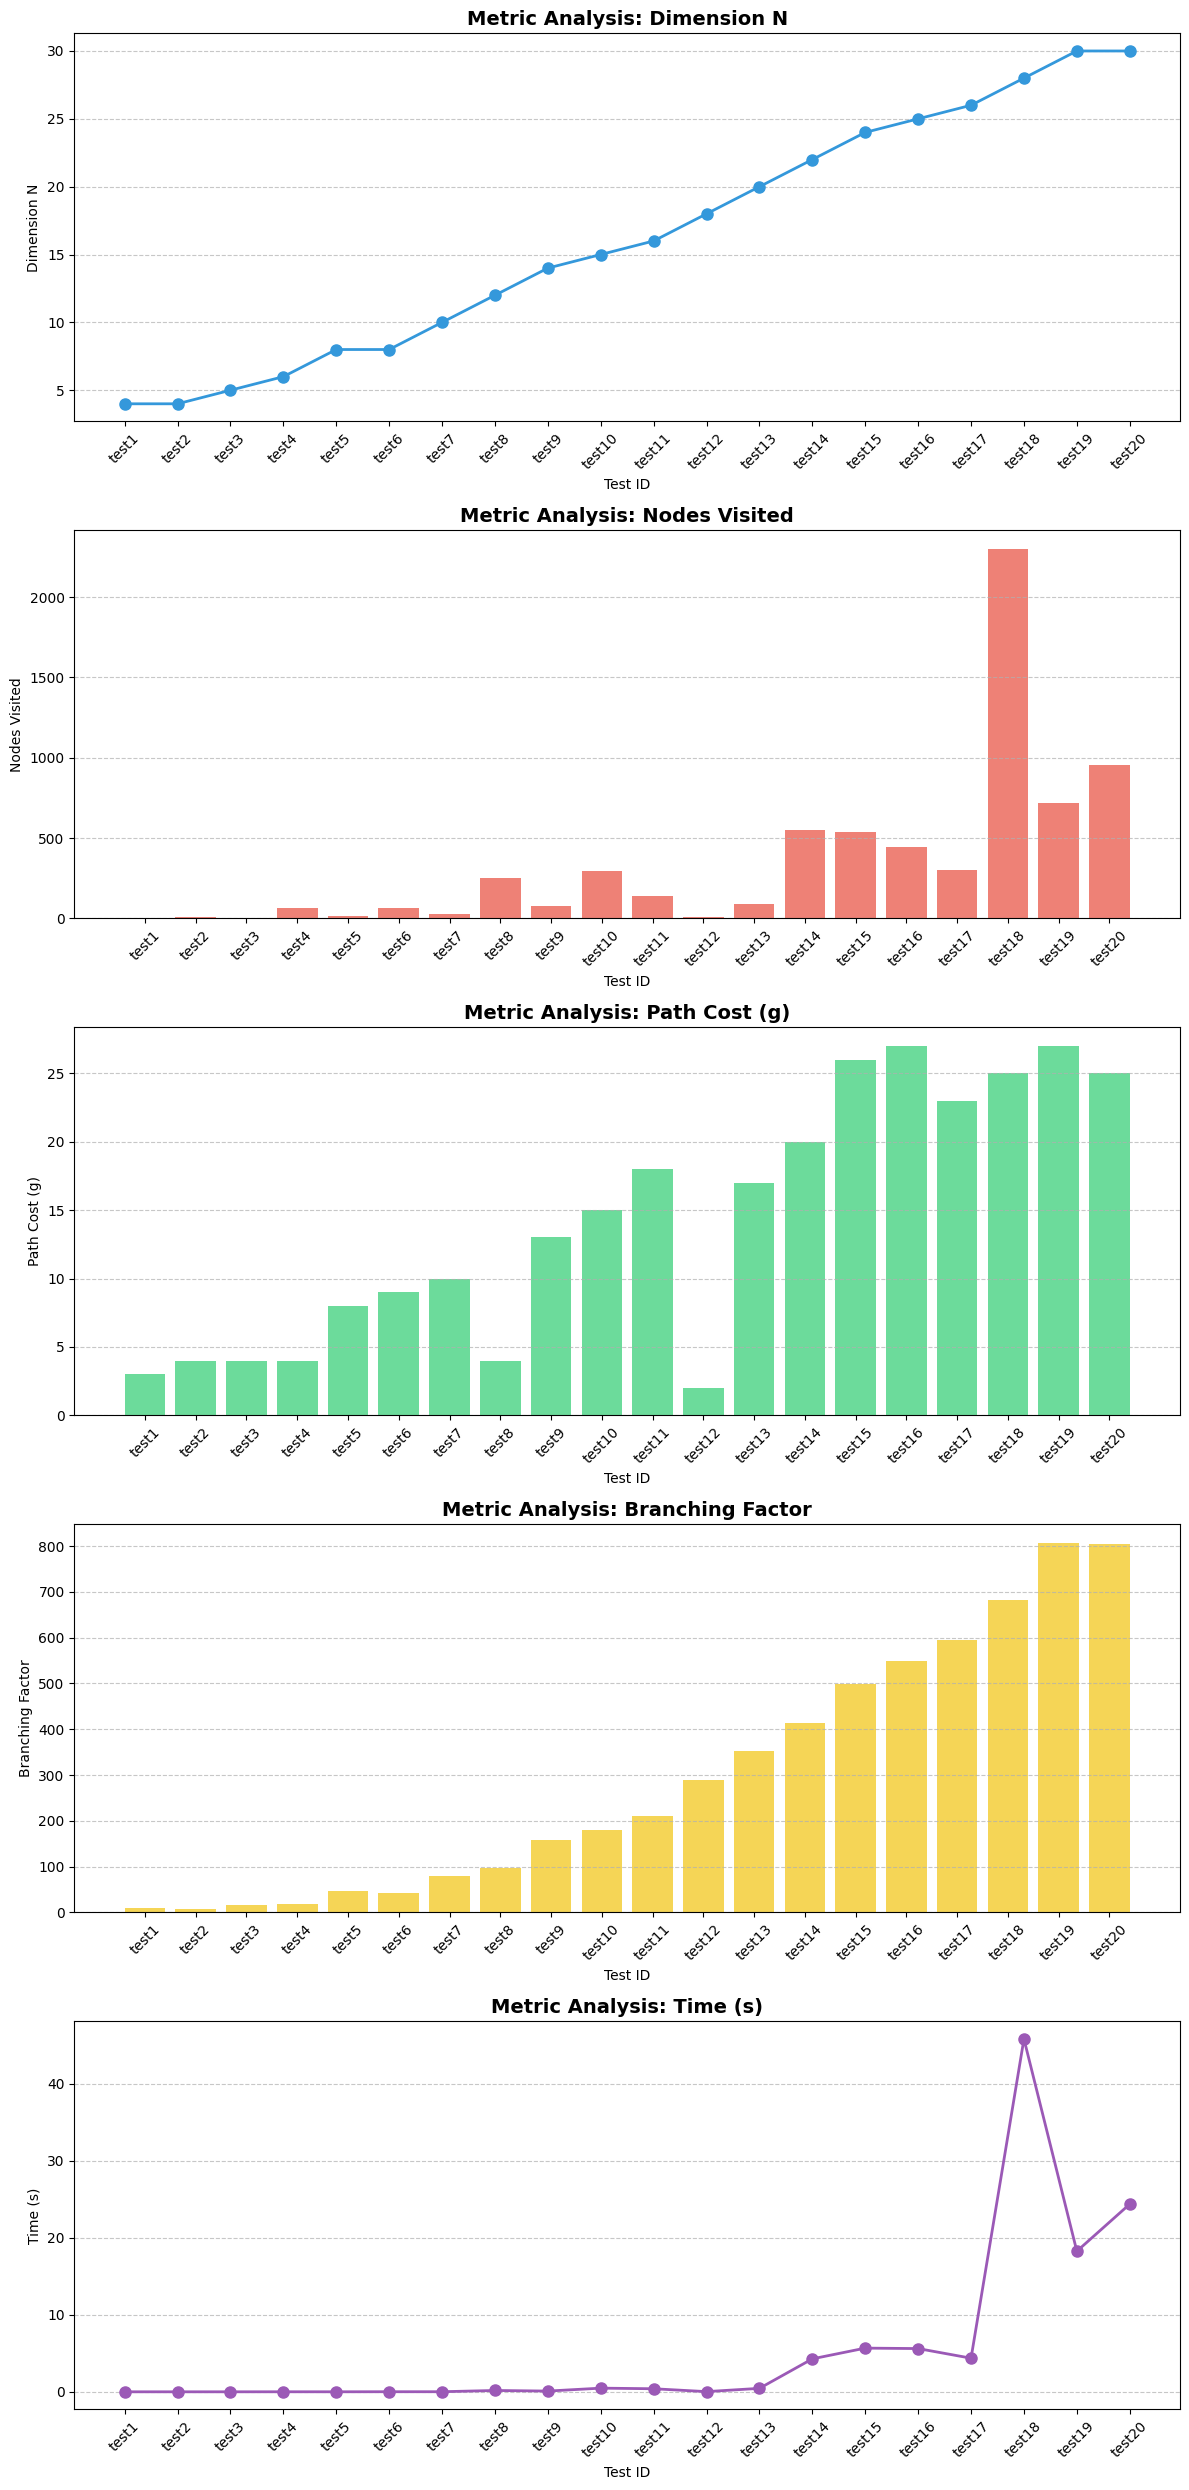

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Create the global DataFrame
df = pd.DataFrame(all_results)

if not df.empty:
    # Cleaning column names for visualization
    df_table = df.copy()
    df_table.columns = ['Test ID', 'Dimension N', 'Nodes Visited', 'Path Cost (g)', 'Branching Factor', 'Time (s)']
    
    print("\n=== METRICS SUMMARY FOR A* ===")
    display(df_table)

    # 2. Automatic generation of charts for each numerical column
    columns_to_plot = [col for col in df_table.columns if col != 'Test ID']
    
    # Create a vertical layout with one chart for each metric
    fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(12, 5 * len(columns_to_plot)))
    
    # In case of a single column, axes is not a list, so we force it
    if len(columns_to_plot) == 1:
        axes = [axes]

    for i, col_name in enumerate(columns_to_plot):
        colors = ['#3498db', '#e74c3c', '#2ecc71', '#f1c40f', '#9b59b6']
        current_color = colors[i % len(colors)]
        
        if col_name in ['Time (s)', 'Dimension N']:
            axes[i].plot(df_table['Test ID'], df_table[col_name], color=current_color, marker='o', linewidth=2, markersize=8)
        else:
            axes[i].bar(df_table['Test ID'], df_table[col_name], color=current_color, alpha=0.7)
        
        axes[i].set_title(f'Metric Analysis: {col_name}', fontsize=14, fontweight='bold')
        axes[i].set_ylabel(col_name)
        axes[i].set_xlabel('Test ID')
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        
        # Rotate X-axis labels to avoid overlap
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(45)

    plt.tight_layout()
    plt.show()
else:
    print("Error: The 'all_results' list is empty. Please ensure you have correctly executed the test cell.")

## 2. Reduction to CSP


Applying the CSP framework to the $n$ queens problem allows for a highly optimized search process. Using the simplification previously discussed, the problem can be formally mapped as follows:
- Variables $V$: A set of $n$ variables $\{Q_1, Q_2, ..., Q_n\}$, where each $Q_i$ represents the queen placed in the $i$-th column.
- Domains $D$: For each variable $Q_i$, the domain $D_i$ consists of integers $\{1, 2, ..., n\}$, representing the possible row positions.
- Constraints $C$: The constraints are defined by the requirement that for any two variables $Q_i$ and $Q_j$ (where $i \neq j$):
    - $Q_i \neq Q_j$ (to ensure they are in different columns).
    - $|Q_i - Q_j| \neq |i - j|$ (to ensure they are not on the same diagonal)
    
    

In [47]:
from ortools.sat.python import cp_model
import time

def solve_n_queens_csp(N):
    model = cp_model.CpModel()
    queens = [model.NewIntVar(0, N - 1, f'q{i}') for i in range(N)]

    # Constraints
    model.AddAllDifferent(queens)
    model.AddAllDifferent([queens[i] + i for i in range(N)])
    model.AddAllDifferent([queens[i] - i for i in range(N)])

    solver = cp_model.CpSolver()
    
    start_time = time.time()
    status = solver.Solve(model)
    end_time = time.time()

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        solution = [solver.Value(queens[i]) for i in range(N)]
        return {
            "solution": solution,
            "time": end_time - start_time,
            "status": "Success",
            "conflicts": solver.NumConflicts(), # Internal solver conflicts
            "branches": solver.NumBranches(),   # Internal solver branches
            "heuristic_check": Board(N, solution).heuristic() 
        }
    else:
        return {"status": "Failure", "time": end_time - start_time}

### Testing the solver
An important distinction between the search-based approach (A*) and the Constraint Satisfaction Problem (CSP) framework lies in the nature of the input. In the previous A* implementation, the algorithm required a specific initial_state (a partial or full board configuration) to begin its exploration of the state space. Instead, the CSP solver does not require an initial arrangement of queens; it only needs the dimension $N$ as input. Since the CSP treats the problem as a set of variables with empty domains that must be filled according to global constraints, the 'starting point' is inherently the empty $n \times n$ board. The solver then systematically assigns values to variables $Q_1, \dots, Q_n$ based on the constraints, moving the focus from transforming a specific input state to finding any assignment that satisfies the mathematical requirements of the problem.

In [48]:
print("=== STARTING CSP SOLVER TEST (OR-Tools) ===")

# Initialize the list to store metrics for the final report
csp_results = []

for test_id in sorted(test_dict.keys(), key=lambda x: int(x[4:])):
    n_val = test_dict[test_id]["N"]
    
    print(f"\n{'='*60}")
    print(f"CSP EXPERIMENT: {test_id} (N={n_val})")
    print(f"{'='*60}")
    
    # Execute the CSP solver
    res = solve_n_queens_csp(n_val)
    
    if res["status"] == "Success":
        solution = res["solution"]
        
        # Re-adding the board printing part
        print(f"FINAL STATE (Solution Found by CSP):")
        print_board(solution, n_val)
        
        print(f"\nMETRICS:")
        print(f"- Execution Time: {res['time']:.4f} s")
        print(f"- Internal Conflicts: {res['conflicts']}")
        print(f"- Internal Branches: {res['branches']}")
        print(f"- Validation (h): {res['heuristic_check']}")
        
        # Saving data for the summary table
        csp_results.append({
            "Test_ID": test_id,
            "N": n_val,
            "CSP_Time": res['time'],
            "Conflicts": res['conflicts'],
            "Branches": res['branches'],
            "Status": "Success"
        })
    else:
        print(f"RESULT: Failure (No solution found for N={n_val})")
    
    print(f"{'-'*60}")

# Create and display the final summary table
df_csp = pd.DataFrame(csp_results)
df_csp.columns = ['Test ID', 'N Dimension', 'Time (s)', 'Conflicts', 'Branches', 'Status']

print("\n===  METRICS SUMMARY FOR CSP ===")
display(df_csp)

=== STARTING CSP SOLVER TEST (OR-Tools) ===

CSP EXPERIMENT: test1 (N=4)
FINAL STATE (Solution Found by CSP):
Board: [2, 0, 3, 1]

       [ , Q,  ,  ]
       [ ,  ,  , Q]
       [Q,  ,  ,  ]
       [ ,  , Q,  ]

METRICS:
- Execution Time: 0.0029 s
- Internal Conflicts: 0
- Internal Branches: 0
- Validation (h): 0
------------------------------------------------------------

CSP EXPERIMENT: test2 (N=4)
FINAL STATE (Solution Found by CSP):
Board: [2, 0, 3, 1]

       [ , Q,  ,  ]
       [ ,  ,  , Q]
       [Q,  ,  ,  ]
       [ ,  , Q,  ]

METRICS:
- Execution Time: 0.0028 s
- Internal Conflicts: 0
- Internal Branches: 0
- Validation (h): 0
------------------------------------------------------------

CSP EXPERIMENT: test3 (N=5)
FINAL STATE (Solution Found by CSP):
Board: [4, 2, 0, 3, 1]

       [ ,  , Q,  ,  ]
       [ ,  ,  ,  , Q]
       [ , Q,  ,  ,  ]
       [ ,  ,  , Q,  ]
       [Q,  ,  ,  ,  ]

METRICS:
- Execution Time: 0.0039 s
- Internal Conflicts: 0
- Internal Branches: 125
-

,Test ID,N Dimension,Time (s),Conflicts,Branches,Status
0,test1,4,0.002929,0,0,Success
1,test2,4,0.002845,0,0,Success
2,test3,5,0.003924,0,125,Success
3,test4,6,0.003460,0,0,Success
4,test5,8,0.004619,9,475,Success
5,test6,8,0.004851,9,475,Success
6,test7,10,0.005613,8,756,Success
7,test8,12,0.007134,11,1106,Success
8,test9,14,0.009139,40,1575,Success
9,test10,15,0.010381,61,1882,Success


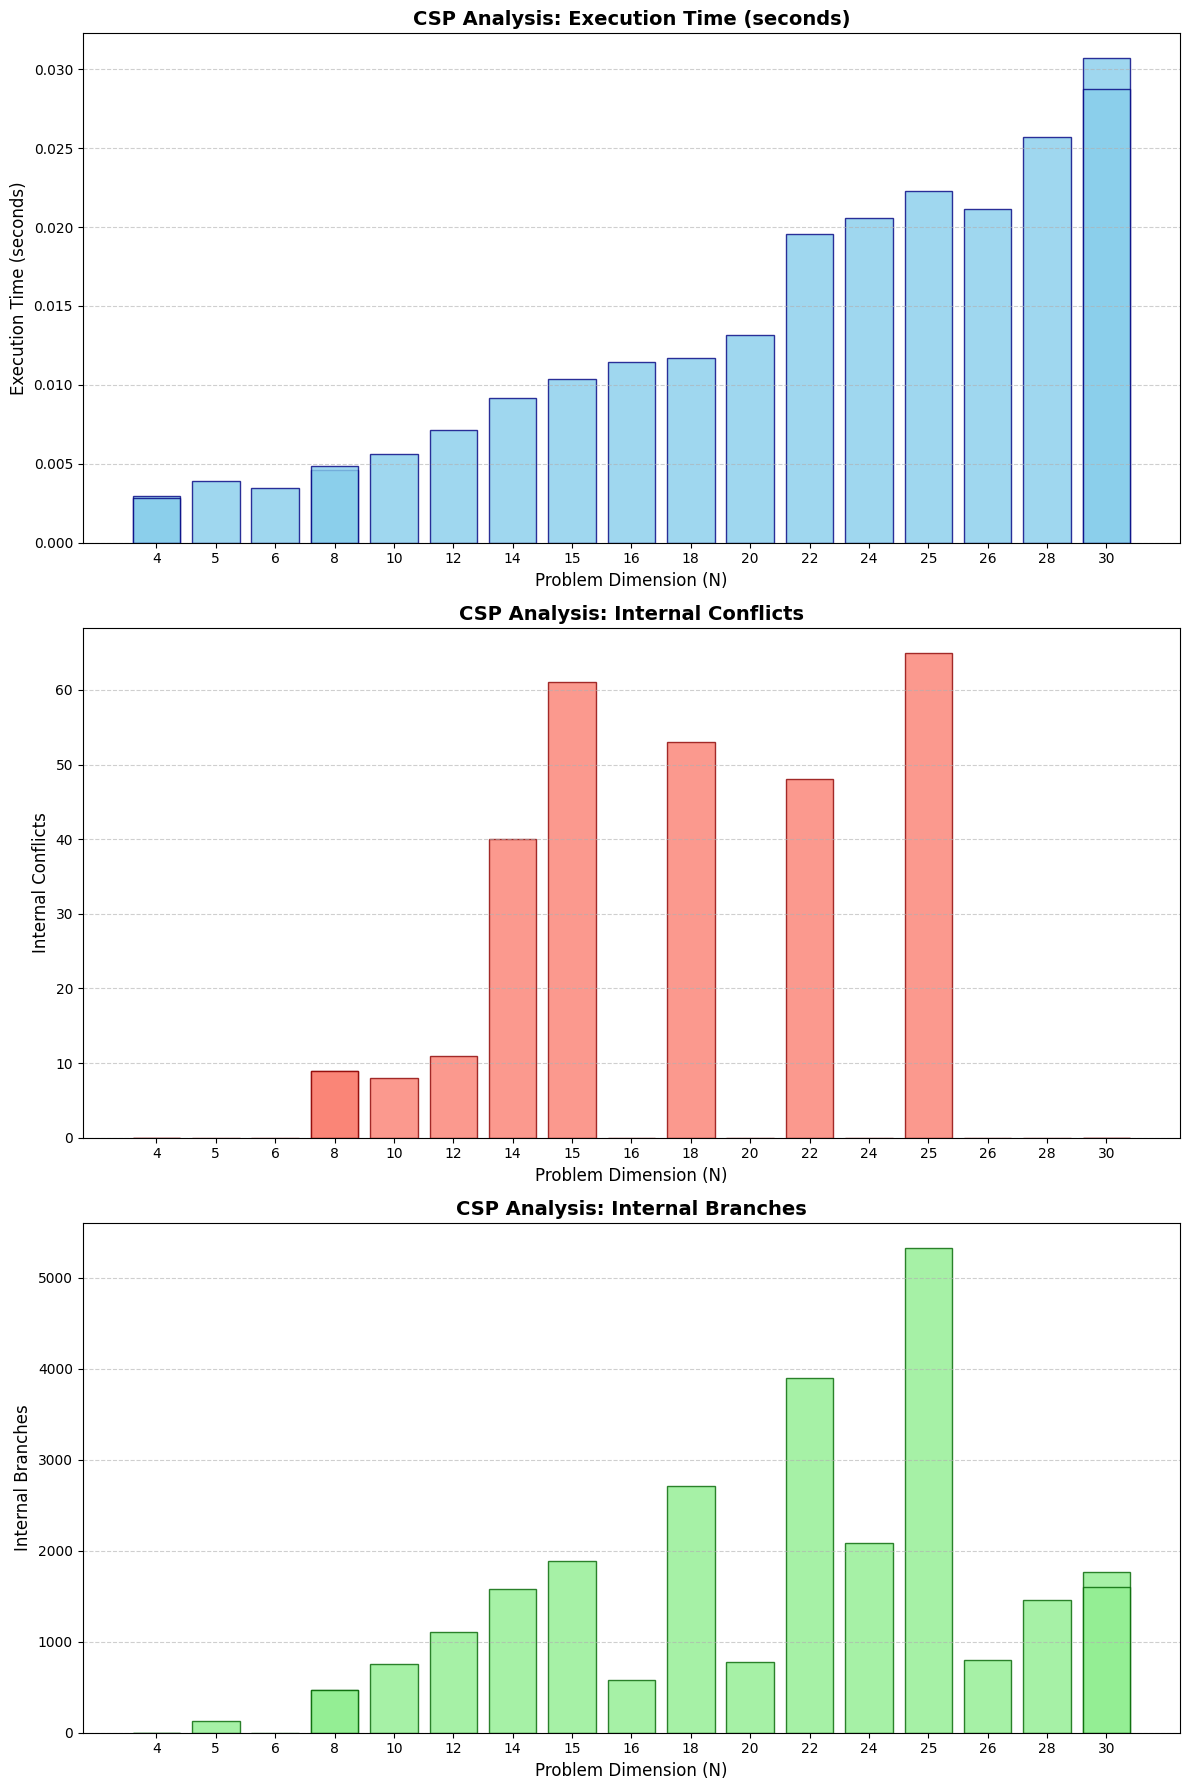

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

df_csp_final = pd.DataFrame(csp_results)

if not df_csp_final.empty:
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
    
    # List of metrics to plot
    metrics = [
        ('CSP_Time', 'Execution Time (seconds)', 'skyblue', 'navy'),
        ('Conflicts', 'Internal Conflicts', 'salmon', 'darkred'),
        ('Branches', 'Internal Branches', 'lightgreen', 'darkgreen')
    ]
    
    for i, (col, ylabel, color, edge) in enumerate(metrics):
        # X_axis -> N, Y-axis -> metric
        axes[i].bar(df_csp_final['N'].astype(str), df_csp_final[col], color=color, edgecolor=edge, alpha=0.8)
        
        # Setting titles and labels
        axes[i].set_title(f'CSP Analysis: {ylabel}', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Problem Dimension (N)', fontsize=12)
        axes[i].set_ylabel(ylabel, fontsize=12)
        axes[i].grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

else:
    print("Error: The 'csp_results' list is empty. Please ensure the CSP test suite has been executed.")